In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import SMOTENC

# Load Data

In [108]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [109]:
df3 = pd.read_csv('data/training_v2.csv')



In [110]:
df3.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [111]:
df3[['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']].head(2)

,apache_2_diagnosis,apache_3j_diagnosis,apache_3j_bodysystem,apache_2_bodysystem
0,113.0,502.01,Sepsis,Cardiovascular
1,108.0,203.01,Respiratory,Respiratory


In [112]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [113]:
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache
df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | (df.h1_lactate_max > 11),True,False)
df['log_bmi'] = np.log2(df.bmi)

In [114]:
df.almost_dead.sum()

1224

In [115]:
df.shape

(91713, 189)

In [116]:
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


In [117]:
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), True, False)

# Drop non_useful features

In [118]:
# columns missing a lot of data. We we instead create a boolean column which will indicate if the data is missing or not

missing = ['h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 
       'h1_platelets_max', 'h1_bun_max', 'h1_creatinine_max',
       'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [119]:
to_remove=['icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob' ] + missing


In [120]:
# df.apache_4a_icu_death_prob.isnull().sum()

In [121]:
# df_n = df[df.apache_2_diagnosis.notnull()]
# df_n.head(2)

In [122]:
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [123]:
apache = [
 'age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 ]

In [124]:
# create a empty dataframe (with NaNs)
df_ = pd.DataFrame(index=apache, columns= diagnosis)
df_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
for d in diagnosis:
    for a in apache:
        df_[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [126]:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [127]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,...,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,almost_dead,log_bmi,bool_h1_lactate_max,diff_age,diff_bmi,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,...,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [128]:
features = [col for col in df.columns]

In [129]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
#                     print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [130]:
drop_columns = drop_correlated_features(df)

In [131]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_albumin_min',
       'h1_bilirubin_min', 'h1_bun_min', 'h1_creatinine_min',
       'h1_hco3_min', 'h1_inr_max', 'h1_inr_min', 'h1_platelets_min',
       'h1_wbc_min', 'diff_age', 'diff_height', 'diff_weight',
       'diff_albumin_apache', 'diff_arf_apache', 'diff_bilirubin_apache',
       'diff_bun_apache', 'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_pao2_apache',
       'diff_ph_apache', 'diff_resprate_apache', 'diff_sodium_apache',
       'diff_temp_apache', 'diff_urineoutput_apache', 'diff_wbc_apache'],
      dtype=object)

In [132]:
features = [col for col in features if col not in drop_columns]

In [133]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [134]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
categorical.append('apache_3j_diagnosis')

In [135]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int8).astype('category')

In [136]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [137]:
df.shape

(91713, 156)

In [138]:
df.hospital_death.value_counts()

1    83798
2     7915
Name: hospital_death, dtype: Int64

In [139]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [140]:
redundant_features = ['readmission_status', 'apache_2_bodysystem',  'apache_3j_diagnosis', 'log_bmi']

In [141]:
df.drop(columns = redundant_features, inplace = True)

In [142]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
numeric_col.remove('apache_3j_diagnosis')
numeric_col.remove('log_bmi')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
categorical.remove('apache_3j_diagnosis')

In [143]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_bodysystem']

In [144]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'bool_h1_lactate_max']

In [145]:
df.shape

(91713, 152)

In [146]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [147]:
# create a empty dataframe (with NaNs)
train_ = pd.DataFrame(index=apache, columns= diagnosis)
train_.head(2)
# create a empty dataframe (with NaNs)
test_ = pd.DataFrame(index=apache, columns= diagnosis)
test_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
for d in diagnosis:
    for a in apache:
        train_[d][a] = train[train.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        train['diff_'+ a] = np.where(train[a].notnull(), train_[d][a] - train[a], 0)

In [149]:
for d in diagnosis:
    for a in apache:
        test_[d][a] = test[test.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        test['diff_'+ a] = np.where(test[a].notnull(), test_[d][a] - test[a], 0)

In [150]:
features = [col for col in train.columns if col not in to_remove]
# redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis'] + missing
# train.drop(columns = redundant_features, inplace = True)

In [151]:
train = train[features]
test = test[features]

In [152]:
# test.drop(columns = features, inplace = True)

In [153]:
numeric_col =[col for col in train.columns if  train[col].dtypes !='object' and col not in binary]

In [154]:
# numeric_col.remove('readmission_status')
# numeric_col.remove('apache_2_diagnosis')
# numeric_col.remove('apache_3j_diagnosis')
# categorical.remove('apache_2_bodysystem')
# categorical.remove('icu_stay_type')
# categorical.remove('apache_2_diagnosis')
# categorical.remove('apache_3j_diagnosis')
numeric_col.remove('hospital_id')
categorical.append('hospital_id')

In [155]:
train.head(2)

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,almost_dead,bool_h1_lactate_max,diff_bmi,diff_ventilated_apache,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_wbc_apache
59226,176,2,72.0,32.041330,1,Caucasian,F,154.9,SDU,Floor,admit,MICU,0.061111,76.88,2.0,113,1,1,2.4,26.0,1.64,NaN,4.0,6.0,1,4.0,107.0,99.0,27.9,1,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,1,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,1,1,1,1,1,1,1,2,Sepsis,14.0,1,1,-5.494076,0.217391,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,-10.286087
81334,18,1,58.0,34.334291,1,Caucasian,M,190.5,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.032639,124.60,2.5,113,1,1,1.2,70.0,2.85,NaN,1.0,1.0,1,1.0,319.0,138.0,37.4,1,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,2,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,1,1,2,1,1,1,1,1,Sepsis,3.0,1,1,-7.787036,-0.782609,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-3.676087


## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [156]:
numeric_df = train[numeric_col]
numeric_df_test = test[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_icu_death_prob,gcs,diff_bmi,diff_ventilated_apache,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_wbc_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,113,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.60,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.70,35.80,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,14.0,-5.494076,0.217391,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,-10.286087
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,113,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.20,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.80,36.20,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.80,37.40,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,3.0,-7.787036,-0.782609,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-3.676087
67173,78.0,32.764004,165.0,2.527083,89.20,NaN,218,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,41.0,NaN,63.0,NaN,NaN,NaN,12.0,NaN,36.33,NaN,NaN,108.0,44.0,70.0,44.0,116.0,63.0,20.0,12.0,98.0,91.0,149.0,104.0,37.22,36.33,85.0,64.0,53.0,50.0,85.0,85.0,18.0,13.0,97.0,97.0,138.0,125.0,37.22,36.44,NaN,NaN,NaN,12.0,12.0,NaN,NaN,0.56,115.0,115.0,23.0,23.0,13.7,13.7,40.7,40.7,NaN,NaN,NaN,NaN,164.0,164.0,4.4,4.4,141.0,141.0,7.59,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,14.0,-6.216749,0.217391,-24.565217,3.102609,-13.976667,0.0,0.565217,0.000000,0.000000,0.00,0.0,0.000000,47.565217,0.000000,0.130435,47.217391,0.0,0.0,0.0,12.173913,0.000000,0.123043,0.0,0.000000


In [157]:
binary_df = train[binary]
binary_df_test = test[binary]


binary_df.head(3)

,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,bool_h1_lactate_max
59226,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1
81334,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1
67173,1,2,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1


In [158]:
categorical_df = train[categorical]
categorical_df_test = test[categorical]
categorical_df.isnull().sum()

ethnicity                 1123
gender                      19
hospital_admit_source    17227
icu_admit_source            92
icu_type                     0
apache_3j_bodysystem      1346
hospital_id                  0
dtype: int64

In [159]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
# from sklearn.impute import KNNImputer


In [58]:
# nan = np.nan
# imputer = KNNImputer(n_neighbors=2, weights="uniform")
# imputer.fit_transform(numeric_df)
# imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [59]:
imp = IterativeImputer(max_iter=3, verbose=0)
imp.fit(numeric_df)
imputed_df = imp.transform(numeric_df)
imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [60]:
impt = IterativeImputer(max_iter=3, verbose=0)
impt.fit(numeric_df_test)
imputed_df_test = impt.transform(numeric_df_test)
imputed_df_test = pd.DataFrame(imputed_df_test, columns=numeric_df_test.columns, index = numeric_df_test.index)

In [160]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [161]:
for col in categorical:
    categorical_df_test[col].fillna(categorical_df_test[col].mode()[0],inplace=True)

In [63]:
imputed_df.head(2)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_icu_death_prob,gcs,diff_bmi,diff_ventilated_apache,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_wbc_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,113.0,2.4,26.0,1.64,0.643403,4.0,6.0,4.0,107.0,99.0,27.9,45.0,40.199463,161.992789,7.368499,13.0,135.0,36.6,4306.897248,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,36.289065,36.218211,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,126.502452,123.332117,45.164584,37.099417,7.343171,7.299273,196.338191,103.365745,258.393424,227.847637,0.11,14.0,-5.494076,0.217391,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,-10.286087
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,113.0,1.2,70.0,2.85,0.643488,1.0,1.0,1.0,319.0,138.0,37.4,47.0,40.199364,161.816145,7.368502,53.0,117.0,36.2,4298.414493,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.800000,37.400000,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,202.011286,216.197506,54.872376,51.483992,7.388580,7.376700,49.952250,98.272488,181.394891,182.022231,0.53,3.0,-7.787036,-0.782609,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-3.676087


In [64]:
imputed_df.shape, imputed_df_test.shape

((73370, 118), (18343, 118))

In [65]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)

# numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])


In [66]:
# numeric_df_scaled

In [162]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df)

# imputed_df_scaled = pd.DataFrame(scaler.transform(imputed_df), columns=imputed_df.columns.values).set_index([imputed_df.index.values])


scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)


numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])




In [204]:
# scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df_test)

# imputed_df_test_scaled = pd.DataFrame(scaler1.transform(imputed_df_test), columns=imputed_df_test.columns.values).set_index([imputed_df_test.index.values])

scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df_test)

numeric_df_test_scaled = pd.DataFrame(scaler1.transform(numeric_df_test), columns=numeric_df_test.columns.values).set_index([numeric_df_test.index.values])



In [205]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 118), (73370, 7), (73370, 16))

# Encoding

## Label encoding


In [163]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_bodysystem     object
hospital_id               int64
dtype: object

In [164]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          25284
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [165]:
from sklearn.preprocessing import OneHotEncoder

In [166]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_bodysystem', 'hospital_id'],
      dtype='object')

In [207]:
binary_df.drop(columns=['hospital_death'], inplace = True)
binary_df_test.drop(columns=['hospital_death'], inplace = True)

KeyError: "['hospital_death'] not found in axis"

In [208]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [209]:
train1 = pd.concat([categorical_df, binary_df], axis =1)
test1 = pd.concat([categorical_df_test, binary_df_test], axis =1)

In [172]:
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_bodysystem,hospital_id,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,bool_h1_lactate_max
59226,Caucasian,F,SDU,Floor,MICU,Sepsis,176,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,Sepsis,18,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1


In [210]:
# train1 = prepare_ravinder.encode(train1, l)
test1 = prepare_ravinder.encode(test1, l)

In [174]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 118), (73370, 7), (73370, 16))

In [175]:
imputed_df.shape, categorical_df.shape, binary_df.shape

NameError: name 'imputed_df' is not defined

In [211]:
# train = pd.concat([imputed_df_scaled ,train1], axis =1)
# test = pd.concat([imputed_df_test_scaled ,test1], axis =1)

train = pd.concat([numeric_df_scaled ,train1], axis =1)
test = pd.concat([numeric_df_test_scaled ,test1], axis =1)



# train

In [212]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'bool_h1_lactate_max']

# Modeling

## Baseline

## Logist regression

### Building a Model

In [178]:
from sklearn.linear_model import LogisticRegression

In [179]:
# param = ['height',
#  'temp_apache',
#  'd1_diasbp_max',
#  'd1_diasbp_min',
#  'd1_heartrate_max',
#  'd1_heartrate_min',
#  'd1_mbp_max',
#  'd1_mbp_min',
#  'd1_spo2_max',
#  'd1_spo2_min',
#  'd1_sysbp_max',
#  'd1_sysbp_min',
#  'd1_temp_max',
#  'd1_temp_min']
# for p in param:  
#     complet_df['bool_'+ p] = np.where(pd.notnull(complet_df[p]), 1,0)

In [213]:
train2, test2 = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [214]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

y_test = test2[['hospital_death']]
y_test['hospital_death'] = y_test['hospital_death']-1
X_test = test

In [215]:
y['hospital_death'] = y['hospital_death'].astype(int)
y_test['hospital_death'] = y_test['hospital_death'].astype(int)

In [216]:
X.shape, y.shape

((73370, 202), (73370, 1))

In [92]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# # pipe = Pipeline([('classifier')])
# # pipe = Pipeline([('classifier', RandomForestClassifier())])

# # Create param grid.
# logistic = LogisticRegression()

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-2, 2, 20),
#     'classifier__solver' : ['liblinear']}
# ]

# # Create grid search object

# clf = GridSearchCV('logistic', param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X, y)

In [93]:
logit = LogisticRegression(C = 100.0, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
logit.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
y_pred = logit.predict(X)

In [86]:
y_pred_test = logit.predict(X_test)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [87]:
feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [126]:
feature_imp.columns = ['feature', 'coeff']
feature_imp.sort_values('coeff').head(199)

,feature,coeff
35,d1_spo2_min,-1.846716
64,d1_hco3_max,-1.797671
67,d1_hemaglobin_min,-1.480160
55,d1_albumin_min,-1.281302
66,d1_hemaglobin_max,-1.149434
...,...,...
81,d1_wbc_min,1.569402
84,d1_arterial_pco2_max,1.604978
56,d1_bilirubin_min,1.742851
69,d1_hematocrit_min,1.812554


In [127]:
# feature_imp.to_csv('data/feature_imp.csv')

### AUC Roc score

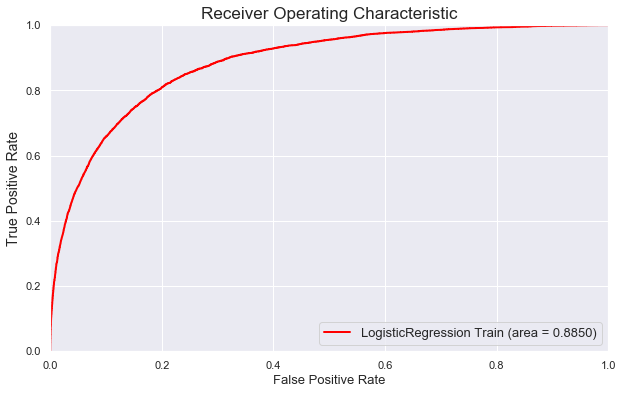

In [128]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

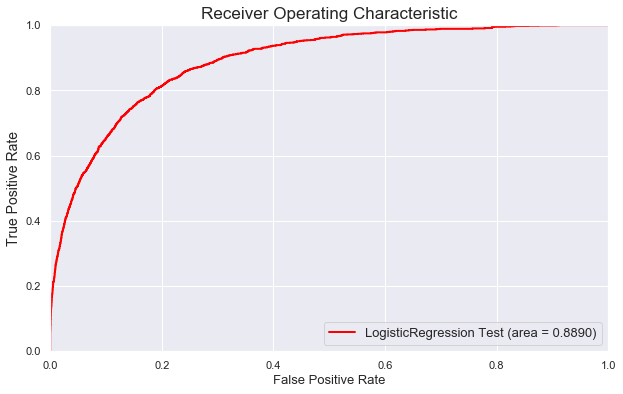

In [129]:
plt.figure(figsize=(10,6))

y_pred_test = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         


# y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# y_pred_test = rf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [130]:
# idx = []
# for i in range(101, 183):
#     idx.append(i)

In [131]:
# sm = SMOTENC(random_state=42, categorical_features = idx)
# x_train_res, y_train_res = sm.fit_sample(X, y)
# print (Y_train.value_counts() , np.bincount(y_train_res))

In [96]:
# logit = LogisticRegression(C = .01, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
# logit.fit(x_train_res, y_train_res)

In [97]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [98]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

## Decision Tree

### Building a model

In [99]:
# from sklearn.tree import DecisionTreeClassifier


In [100]:
# dt = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight={1:2})
# dt.fit(X, y)

In [124]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight= "balanced" , 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=123)

In [125]:
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, random_state=123)

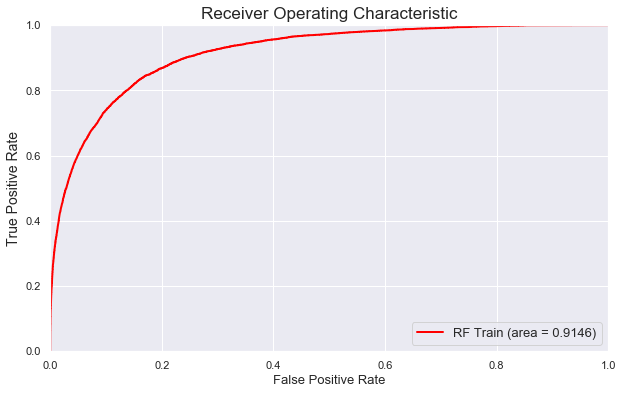

In [126]:
plt.figure(figsize=(10,6))

y_pred = rf.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='RF Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

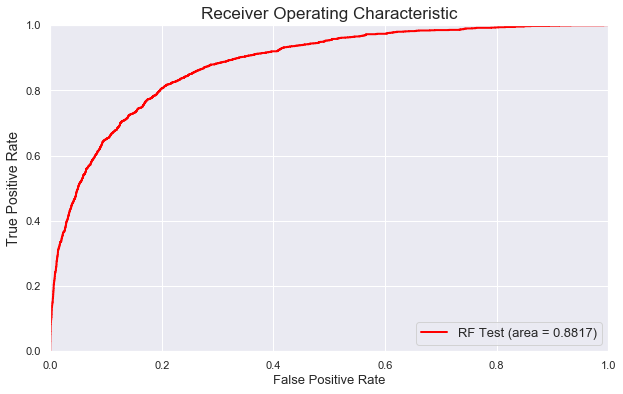

In [127]:
plt.figure(figsize=(10,6))

y_pred = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='RF Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [245]:
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [218]:
X['almost_dead'] = X['almost_dead'].astype(np.float64)
X['bool_h1_lactate_max'] = X['bool_h1_lactate_max'].astype(np.float64)
X_test['almost_dead'] = X_test['almost_dead'].astype(np.float64)
X_test['bool_h1_lactate_max'] = X_test['bool_h1_lactate_max'].astype(np.float64)

In [236]:
def modelfit(alg, dtrain, y ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label= y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y['hospital_death'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y['hospital_death'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y['hospital_death'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [237]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed= 42)
modelfit(xgb1, X, y)


Model Report
Accuracy : 0.9513
AUC Score (Train): 0.954349


TypeError: 'NoneType' object is not callable

In [247]:
param_test1 = {
 'max_depth':range(5,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([173.43613739, 159.57378855, 160.96029   , 245.53084521,
         221.92662539, 214.58699522, 276.91655622, 246.05789566,
         209.99587817]),
  'std_fit_time': array([ 5.57251353,  4.12842604,  5.86338526,  9.6092605 ,  6.80344627,
          8.93874298, 20.80987845,  4.71402173, 41.29415328]),
  'mean_score_time': array([0.38129163, 0.3904057 , 0.36620913, 0.66742315, 0.49797745,
         0.40318441, 0.44263258, 0.44207153, 0.32976198]),
  'std_score_time': array([0.16941628, 0.10936139, 0.10759431, 0.14189287, 0.07927209,
         0.04366608, 0.06405869, 0.03804968, 0.1246762 ]),
  'param_max_depth': masked_array(data=[5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, False,
  

In [249]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([163.18375859, 162.45647397, 161.13430009, 208.49002128,
         190.53939099, 190.1831182 , 225.83498025, 221.12739902,
         184.1899395 ]),
  'std_fit_time': array([ 0.60135373,  0.53653639,  1.55461376,  4.32081405,  1.24682558,
          2.68802686,  2.62424506,  0.8445283 , 49.19620782]),
  'mean_score_time': array([0.35107632, 0.33169765, 0.30296812, 0.42223139, 0.39119239,
         0.45870266, 0.44192214, 0.49534364, 0.35533891]),
  'std_score_time': array([0.10583   , 0.09076662, 0.05158703, 0.04212419, 0.04925553,
         0.03419864, 0.03104412, 0.05059541, 0.11258122]),
  'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
  

In [255]:
model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [256]:
y_pred = model.predict(X)

In [102]:
# model_GB.fit(X , y)

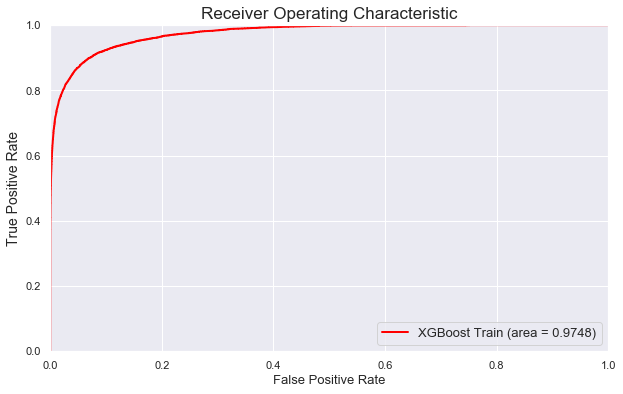

In [257]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

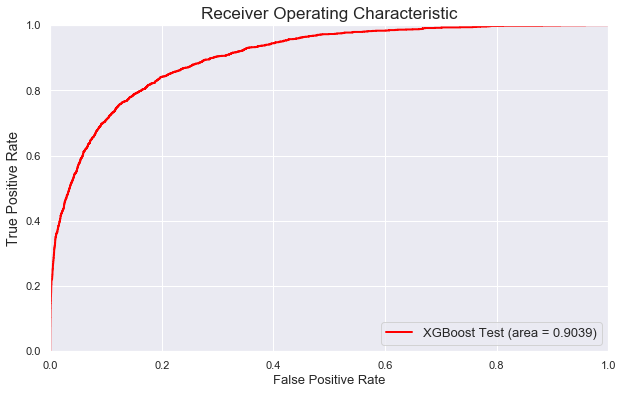

In [258]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [110]:
# from sklearn.ensemble import AdaBoostClassifier
# model_ad = AdaBoostClassifier()
# model_ad.fit(x_train_res , y_train_res)

In [111]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [112]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [113]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# # pprint(random_grid)

In [114]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(random_state = 42)
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X, y)

In [115]:
# train

In [116]:

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

Using TensorFlow backend.


In [117]:
model = Sequential()
model.add(Dense(12, input_dim=201, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [118]:
METRICS = [keras.metrics.AUC(name='auc')]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])

In [119]:
# model.fit(X, y, epochs=100, batch_size=64)

In [120]:
y_pred = model.predict(X)
y_pred

array([[0.47180387],
       [0.48188284],
       [0.3422901 ],
       ...,
       [0.36535934],
       [0.52281255],
       [0.5598078 ]], dtype=float32)

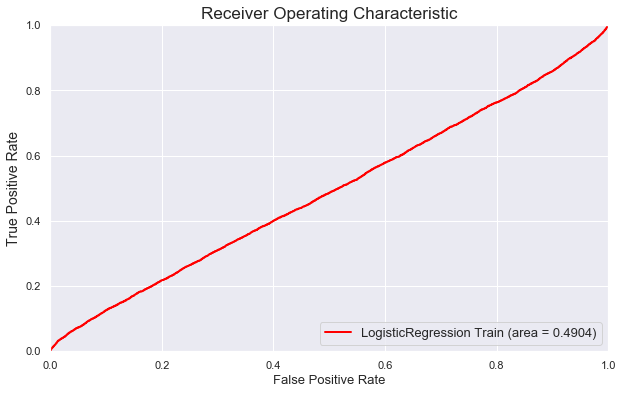

In [121]:
plt.figure(figsize=(10,6))

# y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [122]:
y_pred = model.predict(X_test)

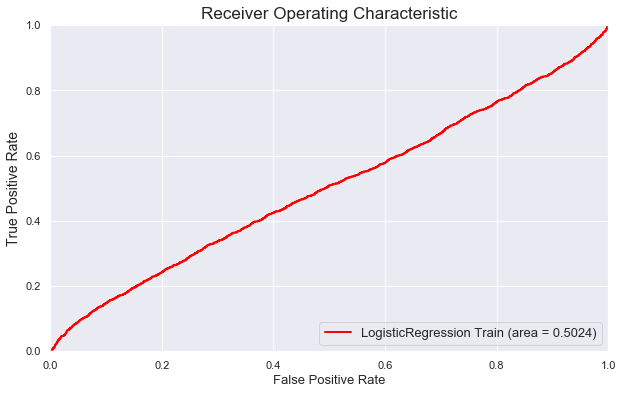

In [123]:
plt.figure(figsize=(10,6))

# y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()